In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as tvt
# from torch.utils.data.sampler import SubsetRandomSampler
import torch_directml
import matplotlib.pyplot as plt
import matplotlib.patches as ph
# from pycocotools.coco import COCO
import numpy as np
# from PIL import Image
import random
import os, time, gc, shutil, copy
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import functools
from DLStudio import *

# use directml to run codes on AMD GPU
dml = torch_directml.device()
# I use the following line in Colab
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # bias = True
        self.Wz = nn.Linear(self.input_size, self.hidden_size)
        self.Wr = nn.Linear(self.input_size, self.hidden_size)
        self.Wh = nn.Linear(self.input_size, self.hidden_size)
        self.Uz = nn.Linear(self.hidden_size, self.hidden_size)
        self.Ur = nn.Linear(self.hidden_size, self.hidden_size)
        self.Uh = nn.Linear(self.hidden_size, self.hidden_size)
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        z = self.sigm(self.Wz(x) + self.Uz(h))
        r = self.sigm(self.Wr(x) + self.Ur(h))
        ht= self.tanh(self.Wh(x) + self.Uh(h*r))            # ht means \tilde{h}
        h_next = h + z*(ht-h)
        output = h_next
        return output, h_next

    
class RNN_1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, *, device="cpu"):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device

        self.gru = MyGRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden = self.init_hidden()
        for k in range(input.shape[1]):
            output, hidden = self.gru(input[0,k].unsqueeze(dim=0), hidden)
        output = self.fc(self.relu(output))
        # there is no LogSoftMax here, 
        # so we should use CrossEntropyLoss as our criterion.
        return output
    
    # from Prof Kak's code
    def init_hidden(self):
        # hidden = weight.new(1, self.hidden_size).zero_()
        hidden = torch.zeros(1, self.hidden_size, dtype=torch.float, device=self.device)
        return hidden
    
class RNN_2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, *, device="cpu", bidirectional=False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device
        self.num_layers = 1
        self.bidirectional = bidirectional

        # self.gru = MyGRU(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size, self.num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * (2 if self.bidirectional else 1), output_size)
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden = self.init_hidden()
        output, hidden = self.gru(input, hidden)
        hidden = hidden.reshape(1,-1)
        output = self.fc(self.relu(hidden))
        # there is no LogSoftMax here, 
        # so we should use CrossEntropyLoss as our criterion.
        return output
    
    def init_hidden(self):
        # hidden = weight.new(1, self.hidden_size).zero_()
        hidden = torch.zeros(2 if self.bidirectional else 1, 1, self.hidden_size, dtype=torch.float, device=self.device)
        return hidden

class Dataset_word2vec(DLStudio.TextClassificationWithEmbeddings.SentimentAnalysisDataset):
    def review_to_tensor(self, review):
        list_of_embeddings = []
        for i,word in enumerate(review):
            if word in self.word_vectors.key_to_index:
                embedding = self.word_vectors[word]
                list_of_embeddings.append(np.array(embedding))
            else:
                next
        # The following line is changed due to the slowness when torch.FloatTensor() applied to list
        # review_tensor = torch.FloatTensor( list_of_embeddings )
        review_tensor = torch.FloatTensor( np.array(list_of_embeddings) )
        return review_tensor

class Parameters(object):
    def __init__(self, device, save_dir, text_cl, epoch_size=1,\
                 *, lr=1e-3, beta=(0.9, 0.99), measure_rate=200 ):
        self.device = device
        self.save_dir = save_dir
        self.epoch_size = epoch_size
        self.lr = lr
        self.betas = beta
        self.train_dataloader = text_cl.train_dataloader
        self.test_dataloader = text_cl.test_dataloader
        self.measure_rate = measure_rate

In [2]:
def train_RNN(net, p, label):
    # net = copy.deepcopy(net)
    start_time = time.perf_counter()
    net = net.to(p.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=p.lr, betas=p.betas)
    loss_record = []
    for epoch in range(1, p.epoch_size+1):
        running_loss = 0.
        epoch_start_time = time.perf_counter()
        for i, data in enumerate(p.train_dataloader):
            review_tensor, sentiment = data['review'], data['sentiment']
            review_tensor = review_tensor.to(p.device)
            sentiment = sentiment.to(p.device)
            optimizer.zero_grad()
            output = net(review_tensor)
            loss = criterion(output, torch.argmax(sentiment,1))
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            j = i+1
            if j % p.measure_rate == 0:
                avg_loss = running_loss/p.measure_rate
                loss_record.append(avg_loss)
                current_time = time.perf_counter()
                time_elapsed = current_time - epoch_start_time
                print("[epoch:%d/%d] [iter:%4d] elapsed time:%4d secs   loss: %.5f"\
                      %(epoch, p.epoch_size, j, time_elapsed, avg_loss) )
                running_loss = 0.
    time_stamp = '_'.join(time.ctime().split(" ")[1:4])
    saved_model = p.save_dir + "saved_model_" + time_stamp
    torch.save(net.state_dict(), saved_model)
    print("model.state_dict() saved to ", saved_model)
    saved_file = p.save_dir + "saved_file_" + time_stamp
    with open(saved_file, 'w') as f:
        for loss in loss_record:
            f.write("%.5f\n" % loss)
        f.flush()
    total_time = time.perf_counter() - start_time
    print("Total training time: %5d secs"%total_time)
    return loss_record, time_stamp

def test_RNN(net, p, time_stamp):
    net.load_state_dict(torch.load(p.save_dir + "saved_model_" + time_stamp))
    accuracy = 0
    cf_matrix = torch.zeros(2,2)
    with torch.no_grad():
        for i, data in enumerate(p.test_dataloader):
            review_tensor, sentiment = data['review'], data['sentiment']
            review_tensor = review_tensor.to(p.device)
            output = net(review_tensor)
            predicted_idx = torch.argmax(output).item()
            gt_idx = torch.argmax(sentiment).item()
            if predicted_idx == gt_idx:
                accuracy += 1
            cf_matrix[gt_idx, predicted_idx] += 1
    accuracy = float(accuracy) / len(p.test_dataloader)
    print("Accuracy: %0.2f%%"%(accuracy*100))
    return cf_matrix

In [3]:
data_root = "/home/parry/gitRepos/homeworks_ECE_60146/DLStudio-2.2.5/Examples/data/"
batch_size = 1

# dataset_archive_train = "sentiment_dataset_train_3.tar.gz"
# dataset_archive_train = "sentiment_dataset_train_40.tar.gz"
dataset_archive_train = "sentiment_dataset_train_400.tar.gz"

# dataset_archive_test =  "sentiment_dataset_test_3.tar.gz"
# dataset_archive_test =  "sentiment_dataset_test_40.tar.gz"
dataset_archive_test = "sentiment_dataset_test_400.tar.gz"

path_to_saved_embeddings = data_root +  "TextDatasets/word2vec/"

dls = DLStudio(
                  dataroot = data_root,
                  path_saved_model = " ",
                  momentum = 0.9,
                  learning_rate =  1e-5,
                  epochs = 1,
                  batch_size = batch_size,
                  classes = ('negative','positive'),
                  use_gpu = False,
              )

text_cl = DLStudio.TextClassificationWithEmbeddings( dl_studio = dls )

# dataserver_train = DLStudio.TextClassificationWithEmbeddings.SentimentAnalysisDataset(
dataserver_train = Dataset_word2vec(
                        train_or_test = 'train',
                        dl_studio = dls,
                        dataset_file = dataset_archive_train,
                        path_to_saved_embeddings = path_to_saved_embeddings,
                   )

# dataserver_train = DLStudio.TextClassificationWithEmbeddings.SentimentAnalysisDataset(
dataserver_test = Dataset_word2vec(
                        train_or_test = 'test',
                        dl_studio = dls,
                        dataset_file = dataset_archive_test,
                        path_to_saved_embeddings = path_to_saved_embeddings,
                  )
text_cl.dataserver_train = dataserver_train
text_cl.dataserver_test = dataserver_test

text_cl.load_SentimentAnalysisDataset(dataserver_train, dataserver_test)

In [4]:
params = Parameters(
    dml,
    "/home/parry/gitRepos/homeworks_ECE_60146/hw8_YuxinSun/",
    # "/home/parry/gitRepos/homeworks_ECE_60146/hw8_YuxinSun/saved_model",
    text_cl,
    epoch_size=4,
    lr=0.1e-2,
    beta=(0.85, 0.9),
)

net = RNN_1(input_size=300, hidden_size=128, output_size=2, device=params.device)
net = net.to(net.device)

In [5]:
loss, time_stamp = train_RNN(net, params, label='1')

cf_matrix = test_RNN(net, params, time_stamp)

/home/parry/.conda/envs/amd-torch/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[epoch:1/4] [iter: 200] elapsed time:  18 secs   loss: 0.69121
[epoch:1/4] [iter: 400] elapsed time:  41 secs   loss: 0.67849
[epoch:1/4] [iter: 600] elapsed time:  59 secs   loss: 0.64238
[epoch:1/4] [iter: 800] elapsed time:  79 secs   loss: 0.64328
[epoch:1/4] [iter:1000] elapsed time: 102 secs   loss: 0.61113
[epoch:1/4] [iter:1200] elapsed time: 130 secs   loss: 0.62766
[epoch:1/4] [iter:1400] elapsed time: 152 secs   loss: 0.61367
[epoch:1/4] [iter:1600] elapsed time: 178 secs   loss: 0.55522
[epoch:1/4] [iter:1800] elapsed time: 196 secs   loss: 0.59046
[epoch:1/4] [iter:2000] elapsed time: 216 secs   loss: 0.59032
[epoch:1/4] [iter:2200] elapsed time: 242 secs   loss: 0.49046
[epoch:1/4] [iter:2400] elapsed time: 268 secs   loss: 0.54037
[epoch:1/4] [iter:2600] elapsed time: 291 secs   loss: 0.46388
[epoch:1/4] [iter:2800] elapsed time: 316 secs   loss: 0.41541
[epoch:1/4] [iter:3000] elapsed time: 338 secs   loss: 0.51871
[epoch:1/4] [iter:3200] elapsed time: 357 secs   loss: 

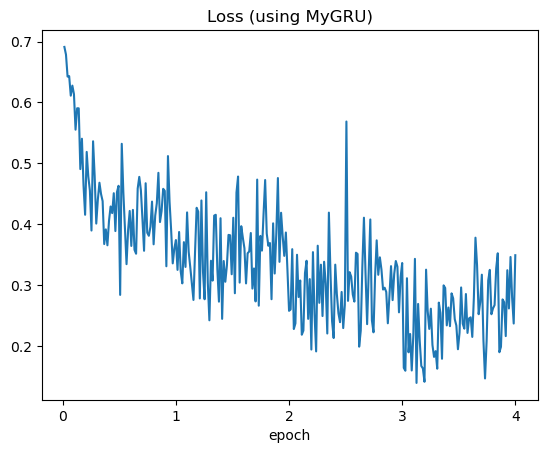

In [8]:
l = len(loss)
plt.plot(np.array(range(1,l+1))/l*4,loss)
plt.xlabel("epoch")
plt.xticks(np.array(range(5)))
plt.title("Loss (using MyGRU)")
plt.show()

tensor([[1502.,  150.],
        [ 345., 1566.]])


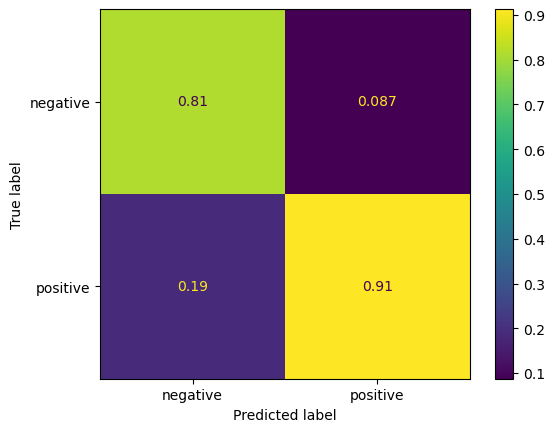

In [9]:
print(cf_matrix)
arr = np.array(cf_matrix)
arr = arr / np.linalg.norm(arr, ord=1, axis=0)
cf = ConfusionMatrixDisplay(arr, display_labels=["negative","positive"])
cf.plot()
plt.show()